## **Import Libraries and Data**

In [116]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import sqlite3
from datetime import datetime 

from scipy import stats 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
                      
pd.set_option('display.max_columns', None)

In [82]:
db = sqlite3.connect("/Users/kelvinfoo/Desktop/AI Masters/AI610 Project/noshow.db")
cursor = db.cursor()
df = pd.read_sql_query(sql = "SELECT * FROM noshow", con = db)

print(df.shape)
df.head()

(119391, 15)


,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
0,94113,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,SGD$ 492.98,Website,1,0.0
1,86543,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,SGD$ 1351.22,Website,2,0.0
2,75928,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,None,Agent,1,0.0
3,66947,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,SGD$ 666.04,Website,1,0.0
4,106390,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,USD$ 665.37,Website,1,0.0


#### **Check for Null and Duplicate Values**

In [83]:
# Check for null values 
print("Number of null values: ", df.isnull().sum())

# Check for duplicate booking id 
df[df.duplicated(subset = ['booking_id']) == True]

Number of null values:  booking_id            0
no_show               1
branch                1
booking_month         1
arrival_month         1
arrival_day           1
checkout_month        1
checkout_day          1
country               1
first_time            1
room              21613
price             24882
platform              1
num_adults            1
num_children          1
dtype: int64


,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children


<div class="alert alert-block alert-info" style="background-color: #FEDAE8; color: black;">
- There were no duplicate booking id. All bookings in the database were unique. </br> 
- About 20% of values were missing in columns for room and price. 
</div>

In [84]:
# Check row where value is missing for all columns 
df[df['no_show'].isnull() == True] # Null values for all columns for booking id 115536

# Since the row does not contribute any meaningful information, we remove the row from the dataset. 
df = df[df['booking_id'] != 115536]
print("Number of null values: ", df.isnull().sum())

Number of null values:  booking_id            0
no_show               0
branch                0
booking_month         0
arrival_month         0
arrival_day           0
checkout_month        0
checkout_day          0
country               0
first_time            0
room              21612
price             24881
platform              0
num_adults            0
num_children          0
dtype: int64


In [85]:
df['room_null'] = df['room'].isnull().astype(int)
df['price_null'] = df['price'].isnull().astype(int)

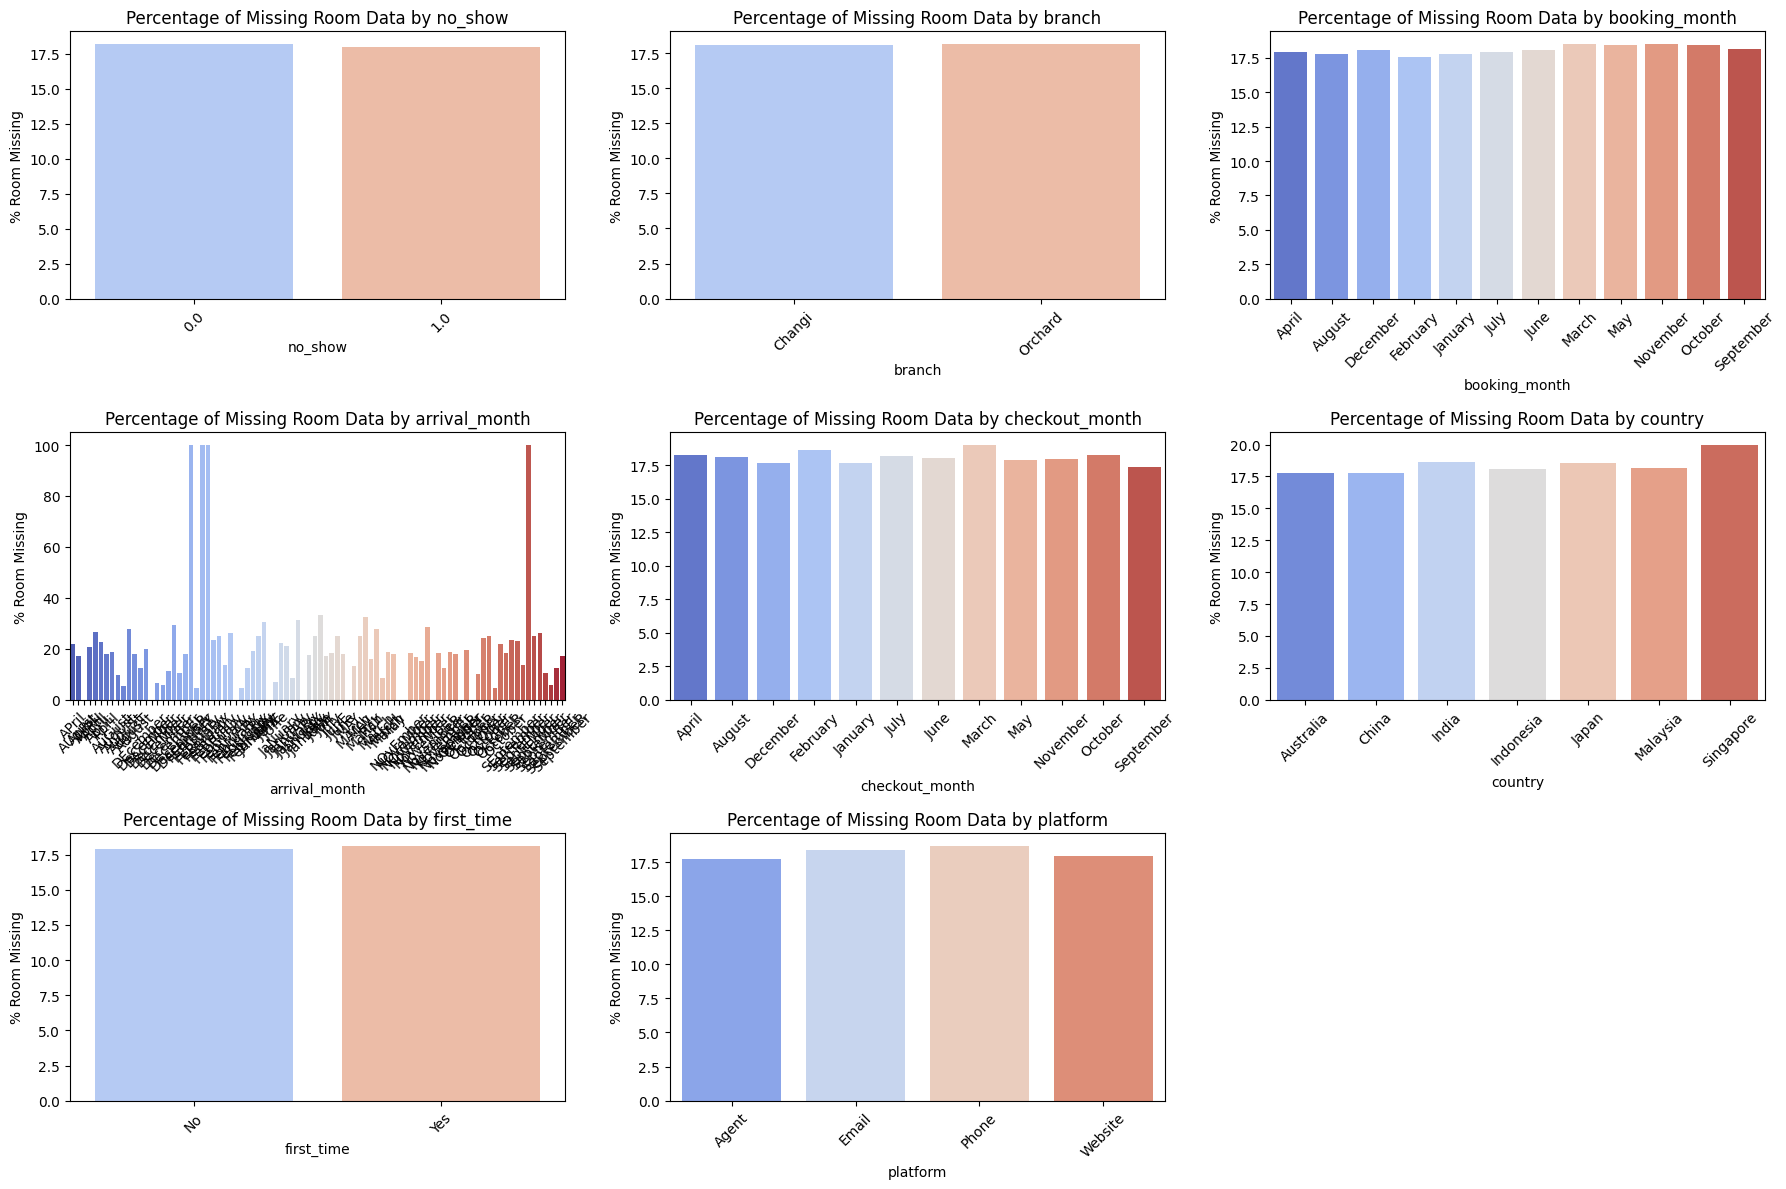

In [86]:
columns_to_plot = ['no_show', 'branch', 'booking_month', 'arrival_month', 
                   'checkout_month', 'country', 'first_time', 'platform']

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()  

for i, col in enumerate(columns_to_plot):
    percentage_missing = df.groupby(col)['room_null'].mean() * 100
    
    sns.barplot(x=percentage_missing.index, y=percentage_missing.values, ax=axes[i], palette='coolwarm')
    axes[i].set_title(f'Percentage of Missing Room Data by {col}', fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('% Room Missing', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)  

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info" style="background-color: #FEDAE8; color: black;">
- Bookings from Singapore had a higher percentage of missing room data compared to bookings from other countries. </br>
- There were significantly higher percentage of missing room values for several arrival months. 
</div>

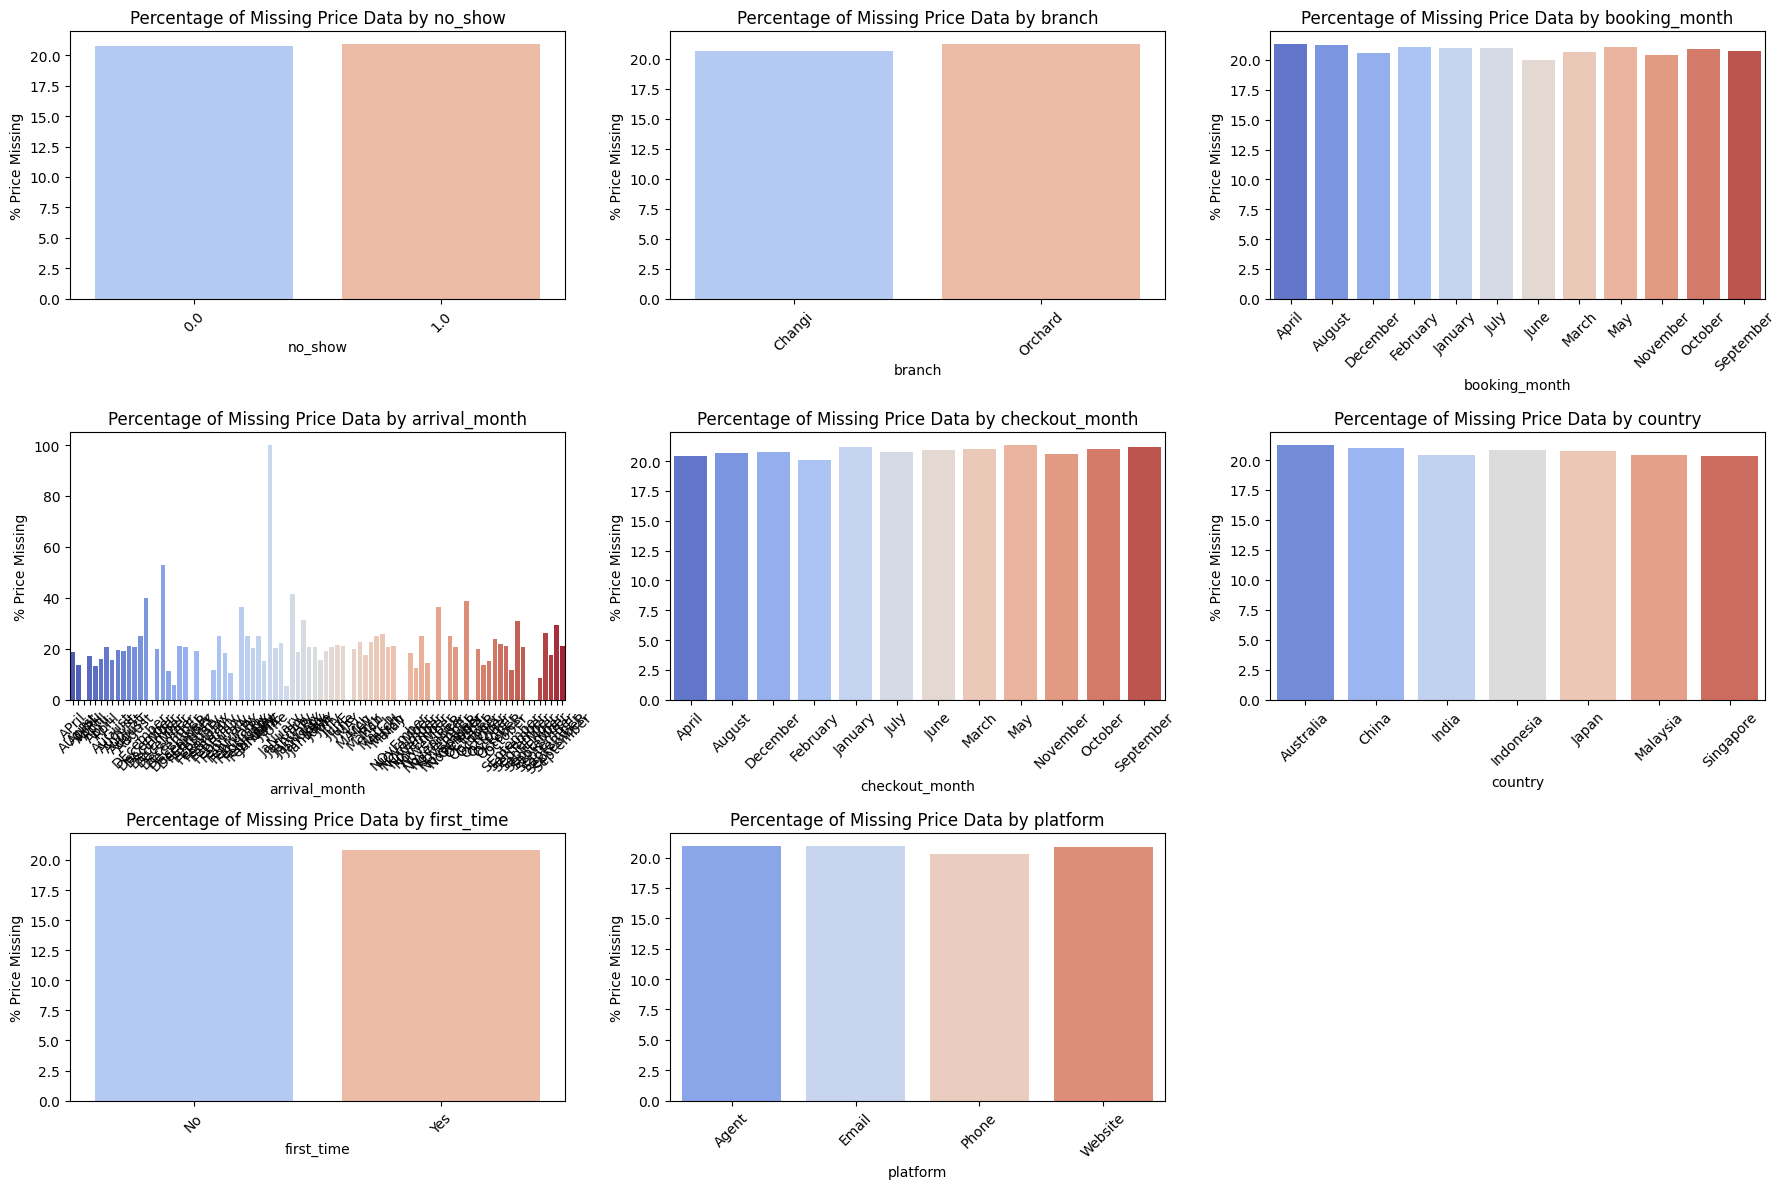

In [87]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()  

for i, col in enumerate(columns_to_plot):
    percentage_missing = df.groupby(col)['price_null'].mean() * 100
    
    sns.barplot(x=percentage_missing.index, y=percentage_missing.values, ax=axes[i], palette='coolwarm')
    axes[i].set_title(f'Percentage of Missing Price Data by {col}', fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('% Price Missing', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)  

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info" style="background-color: #FEDAE8; color: black;">
There were significantly higher percentage of missing price values for several arrival months. 
</div>

#### **Inconsistencies in values and labels**

In [88]:
categorical_variables = ['no_show', 'branch', 'booking_month', 'arrival_month', 
                         'checkout_month', 'country', 'first_time', 'platform']

for col in categorical_variables: 
    print(f"Value counts for {col}: \n")
    print(df[col].value_counts())

Value counts for no_show: 

no_show
0.0    75166
1.0    44224
Name: count, dtype: int64
Value counts for branch: 

branch
Changi     79330
Orchard    40060
Name: count, dtype: int64
Value counts for booking_month: 

booking_month
June         10324
September    10315
November     10280
January      10214
August       10134
October      10068
July          9993
March         9754
May           9588
February      9588
April         9571
December      9561
Name: count, dtype: int64
Value counts for arrival_month: 

arrival_month
August       13695
July         12515
May          11684
October      11009
April        10966
             ...  
MAY              1
SeptEMber        1
ApRiL            1
OcTobeR          1
FeBruaRy         1
Name: count, Length: 88, dtype: int64
Value counts for checkout_month: 

checkout_month
August       13836
July         12760
May          12044
October      11434
April        11016
June         10692
September    10416
March         9509
February      7716


In [89]:
df['arrival_month'].unique().tolist()

['June',
 'November',
 'February',
 'October',
 'September',
 'March',
 'May',
 'August',
 'July',
 'January',
 'April',
 'December',
 'ApRiL',
 'OcTobeR',
 'JuNe',
 'JulY',
 'ApriL',
 'OctOber',
 'DecembEr',
 'SeptEmber',
 'JanUary',
 'JUne',
 'FeBruary',
 'JanuarY',
 'DEcember',
 'SePtember',
 'DecembeR',
 'MaY',
 'NoVember',
 'JUly',
 'JunE',
 'JuLy',
 'FebrUary',
 'NOvember',
 'SeptemBer',
 'OctobeR',
 'DecemBer',
 'MarCh',
 'AuguSt',
 'AugusT',
 'APril',
 'SepTember',
 'NovembEr',
 'FEbruary',
 'DeceMber',
 'AuGust',
 'SepteMber',
 'FebruaRy',
 'OctoBer',
 'JanuaRy',
 'MarcH',
 'ApRil',
 'AUgust',
 'JanuAry',
 'NOveMber',
 'MaRch',
 'AprIl',
 'MAy',
 'NovemBer',
 'DecEmber',
 'MArch',
 'JaNuary',
 'NovembeR',
 'SeptembEr',
 'FebruarY',
 'SeptembeR',
 'OcTober',
 'DeCember',
 'FebruAry',
 'AugUst',
 'NovEmber',
 'NoveMber',
 'OctobEr',
 'OCtober',
 'SEptember',
 'JAnuary',
 'SeptEMber',
 'MAY',
 'FebRuary',
 'FeBruarY',
 'OCTober',
 'JUnE',
 'DecEMber',
 'FebruaRY',
 'NovemBeR',
 '

<div class="alert alert-block alert-info" style="background-color: #FEDAE8; color: black;">
The column arrival_month had inconsistent naming of months (eg. MAY and May). However, it seems that it can be solved by using lowercase letters for that column. 
</div>

In [90]:
# Lowercase all arrival month values 

df['arrival_month'] = df['arrival_month'].str.lower()
df['arrival_month'].value_counts()

arrival_month
august       13877
july         12661
may          11791
october      11160
april        11089
june         10939
september    10508
march         9794
february      8068
november      6794
december      6780
january       5929
Name: count, dtype: int64

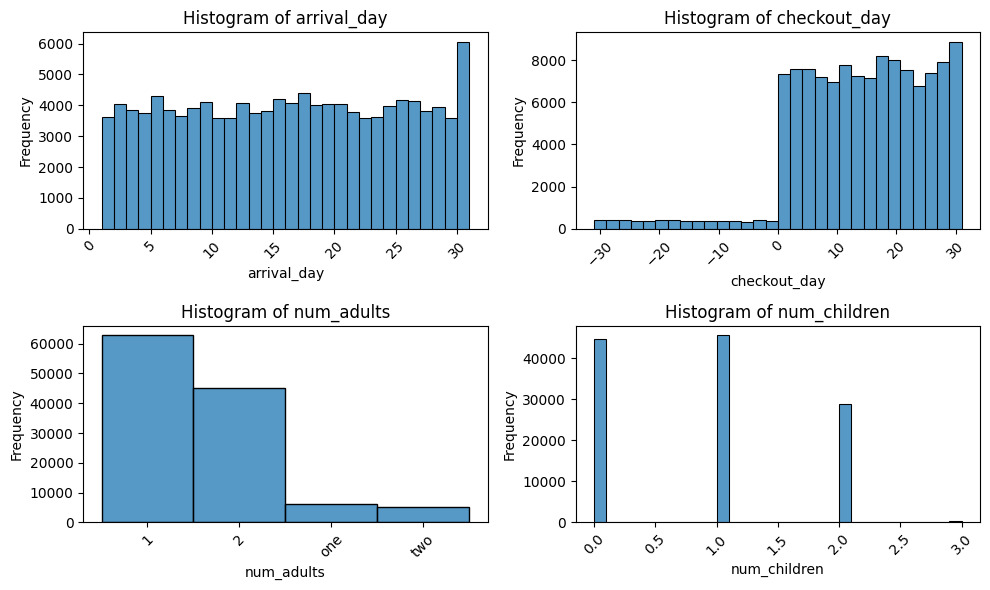

In [91]:
columns_to_plot = ['arrival_day', 'checkout_day', 'num_adults', 'num_children']

fig, axes = plt.subplots(2, 2, figsize=(10, 6))  
axes = axes.flatten()  

for i, col in enumerate(columns_to_plot):
    sns.histplot(df[col], bins=30, ax=axes[i])  
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].set_title(f'Histogram of {col}', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)  

if len(columns_to_plot) < len(axes):
    fig.delaxes(axes[-1])  

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info" style="background-color: #FEDAE8; color: black;">
- Inconsistent label for num_adults (eg. 1 vs one). </br> 
- Negative values present in checkout_day.
</div>

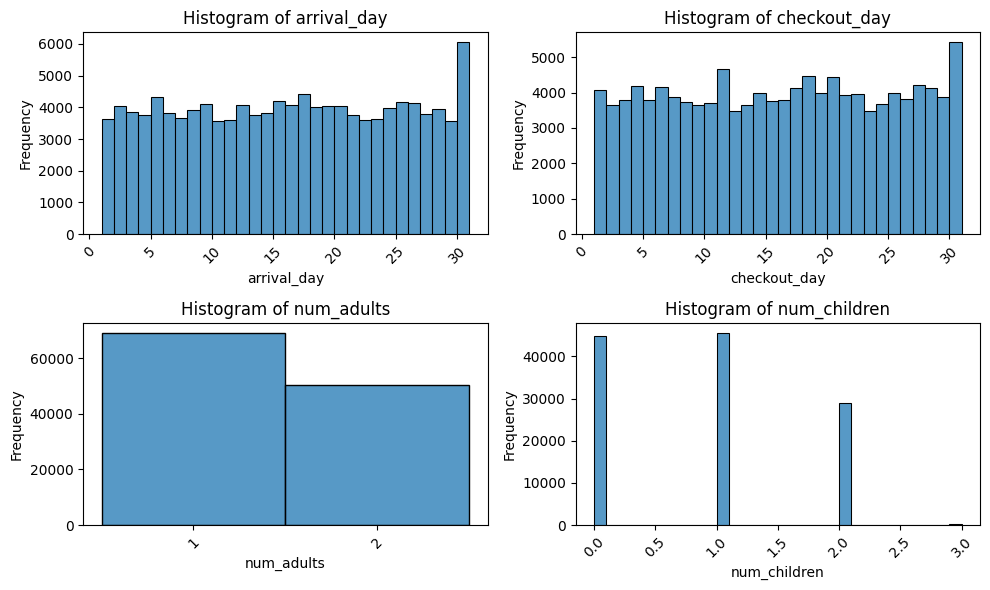

In [92]:
# Take absolute values for checkout day to eliminate negative values 
# Ensure consistent value for number of adults 

df['checkout_day'] = abs(df['checkout_day'])
df['num_adults'] = df['num_adults'].apply(lambda x: '1' if x == 'one' else '2' if x == 'two' else x) 

columns_to_plot = ['arrival_day', 'checkout_day', 'num_adults', 'num_children']

fig, axes = plt.subplots(2, 2, figsize=(10, 6))  
axes = axes.flatten()  

for i, col in enumerate(columns_to_plot):
    sns.histplot(df[col], bins=30, ax=axes[i])  
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].set_title(f'Histogram of {col}', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)  

if len(columns_to_plot) < len(axes):
    fig.delaxes(axes[-1])  

plt.tight_layout()
plt.show()

In [93]:
# Extract currency used in price 

df['currency'] = df['price'].str.extract(r'([A-Z]{3})')
df['price'] = df['price'].str.extract(r'[\$]?([\d,]+)').astype(float)
print(df['currency'].value_counts())
df.head()


currency
SGD    47295
USD    47214
Name: count, dtype: int64


,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children,room_null,price_null,currency
0,94113,0.0,Changi,November,june,25.0,June,27.0,Singapore,Yes,Single,492.0,Website,1,0.0,0,0,SGD
1,86543,0.0,Orchard,August,november,28.0,November,29.0,Indonesia,Yes,King,1351.0,Website,2,0.0,0,0,SGD
2,75928,0.0,Changi,March,february,7.0,February,11.0,India,Yes,Single,NaN,Agent,1,0.0,0,1,NaN
3,66947,1.0,Orchard,September,october,1.0,October,3.0,China,Yes,Single,666.0,Website,1,0.0,0,0,SGD
4,106390,0.0,Orchard,March,june,20.0,June,24.0,Australia,Yes,Queen,665.0,Website,1,0.0,0,0,USD


In [94]:
# Convert price to common SGD currency (Exchange rate: 1 USD = 1.34 SGD)

df['price'] = df.apply(lambda row: row['price'] * 1.34 if row['currency'] == 'USD' else row['price'], axis = 1)
df.drop(['currency'], axis = 1, inplace = True)
df.head()

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children,room_null,price_null
0,94113,0.0,Changi,November,june,25.0,June,27.0,Singapore,Yes,Single,492.0,Website,1,0.0,0,0
1,86543,0.0,Orchard,August,november,28.0,November,29.0,Indonesia,Yes,King,1351.0,Website,2,0.0,0,0
2,75928,0.0,Changi,March,february,7.0,February,11.0,India,Yes,Single,NaN,Agent,1,0.0,0,1
3,66947,1.0,Orchard,September,october,1.0,October,3.0,China,Yes,Single,666.0,Website,1,0.0,0,0
4,106390,0.0,Orchard,March,june,20.0,June,24.0,Australia,Yes,Queen,891.1,Website,1,0.0,0,0


## **Imputation of Missing Values**
#### **Impute Missing Room Values**
If total family size is 2 or less, assign single. If total family size is greater than 2, assign king. 

In [95]:
# Check family size for each room type 
df['total_fam'] = df['num_adults'].astype(float) + df['num_children'].astype(float)
df['total_fam_str'] = df['total_fam'].astype(str)
pd.crosstab(df.room, df.total_fam_str)

total_fam_str,1.0,2.0,3.0,4.0,5.0
room,,,,,
King,11556,23531,23590,11819,0
President Suite,94,184,191,175,117
Queen,2728,5353,2743,0,0
Single,7633,8035,29,0,0


In [96]:
# If total family size is 2 or less, assign single. 
# If total family soze is greater than 2, assign king. 

df['room'] = df.apply(lambda row: 'Single' if (row['total_fam'] <= 2) & (row['room_null'] == 1) else 'King' if (row['total_fam'] >= 3) & (row['room_null'] == 1) else row['room'], axis = 1)
print(df.isnull().sum())
df.tail()

booking_id            0
no_show               0
branch                0
booking_month         0
arrival_month         0
arrival_day           0
checkout_month        0
checkout_day          0
country               0
first_time            0
room                  0
price             24881
platform              0
num_adults            0
num_children          0
room_null             0
price_null            0
total_fam             0
total_fam_str         0
dtype: int64


,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children,room_null,price_null,total_fam,total_fam_str
119386,4823,0.0,Changi,September,april,3.0,April,5.0,China,Yes,King,820.08,Website,1,1.0,0,0,2.0,2.0
119387,25062,0.0,Orchard,March,december,30.0,January,3.0,China,Yes,King,1394.94,Email,2,0.0,0,0,2.0,2.0
119388,81936,1.0,Changi,September,march,31.0,April,1.0,Indonesia,Yes,King,858.94,Email,1,2.0,0,0,3.0,3.0
119389,6738,0.0,Changi,February,february,25.0,February,27.0,China,Yes,Single,886.00,Website,2,0.0,1,0,2.0,2.0
119390,99643,0.0,Changi,March,july,18.0,July,26.0,India,Yes,King,901.00,Website,1,2.0,0,0,3.0,3.0


#### **Impute Missing Price Values** 
Use regression model to predict room price based on difference in number of months between booking and arrival month, arrival month, platform, branch and room. 

In [97]:
df['booking_month'] = df['booking_month'].str.lower()
df['checkout_month'] = df['checkout_month'].str.lower()

# Determine number of months between booking month and arrival month 
month_mapping = {
    'january': 1, 'february': 2, 'march': 3, 'april': 4, 'may': 5, 'june': 6,
    'july': 7, 'august': 8, 'september': 9, 'october': 10, 'november': 11, 'december': 12
}

df['booking_month'] = df['booking_month'].map(month_mapping)
df['arrival_month'] = df['arrival_month'].map(month_mapping)

df['month_diff'] = df.apply(lambda row: (row['arrival_month'] - row['booking_month']) % 12, axis = 1)
df['month_diff'] = df['month_diff'].apply(lambda x: x if x > 0 else x + 12)

df.head()

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children,room_null,price_null,total_fam,total_fam_str,month_diff
0,94113,0.0,Changi,11,6,25.0,june,27.0,Singapore,Yes,Single,492.0,Website,1,0.0,0,0,1.0,1.0,7
1,86543,0.0,Orchard,8,11,28.0,november,29.0,Indonesia,Yes,King,1351.0,Website,2,0.0,0,0,2.0,2.0,3
2,75928,0.0,Changi,3,2,7.0,february,11.0,India,Yes,Single,NaN,Agent,1,0.0,0,1,1.0,1.0,11
3,66947,1.0,Orchard,9,10,1.0,october,3.0,China,Yes,Single,666.0,Website,1,0.0,0,0,1.0,1.0,1
4,106390,0.0,Orchard,3,6,20.0,june,24.0,Australia,Yes,Queen,891.1,Website,1,0.0,0,0,1.0,1.0,3


<Axes: xlabel='arrival_month', ylabel='price'>

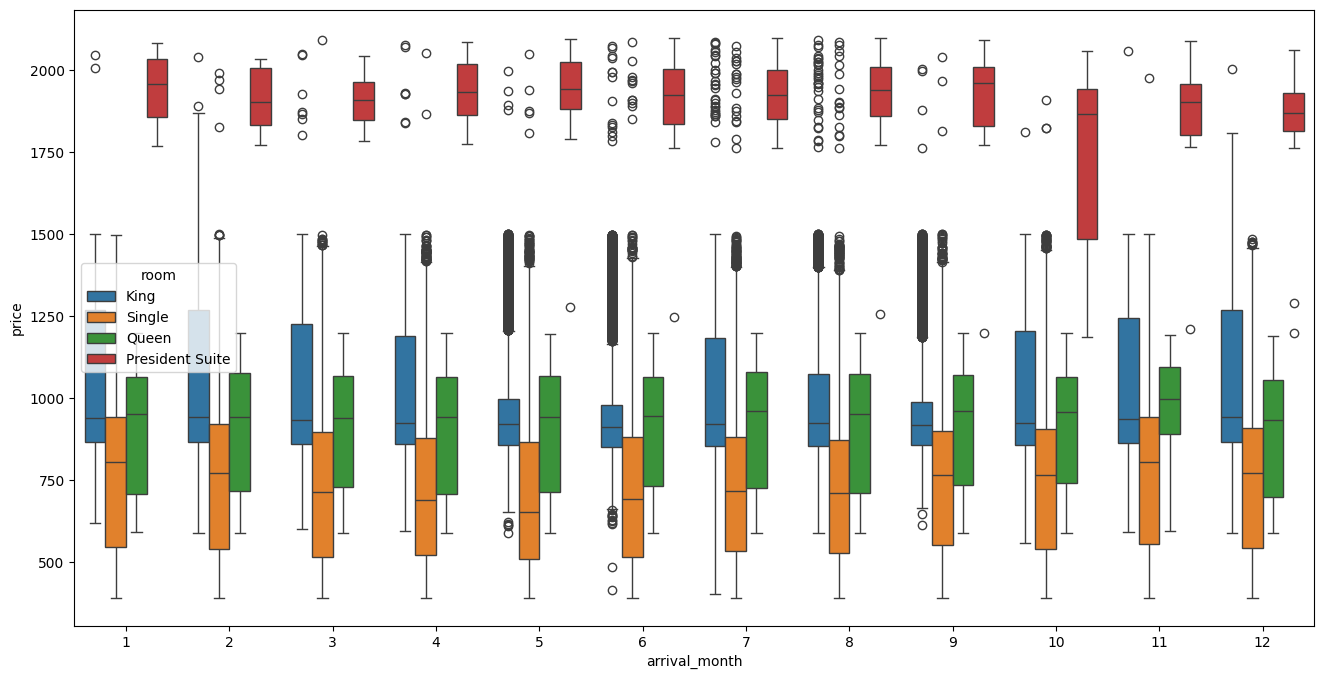

In [98]:
# Check if price for each room type are higher in specific months 
plt.figure(figsize = (16,8))
sns.boxplot(x = 'arrival_month', y = 'price', hue = 'room', data = df)

<div class="alert alert-block alert-info" style="background-color: #FEDAE8; color: black;">
Certain months have wider spread in price. May be good to include arrival month in predicting price since certain arrival months may have higher demand, leading to higher price. 
</div>

In [ ]:
df_encode = pd.get_dummies(df, columns=['arrival_month', 'platform', 'branch', 'room'], 
                           prefix=['arrival_month', 'platform', 'branch', 'room'])

price_not_null = df_encode[df_encode['price_null'] == 0]
X_train = price_not_null.iloc[:, 15:]  
y_train = price_not_null['price']      

random_forest = RandomForestRegressor(random_state=42)
random_forest.fit(X_train, y_train)

price_null = df_encode[df_encode['price_null'] == 1]
X_test = price_null.iloc[:, 15:]  

predicted_prices = random_forest.predict(X_test)

predicted_df = pd.DataFrame({
    'booking_id': price_null['booking_id'],
    'predicted_price': predicted_prices
})

df = df.merge(predicted_df, on='booking_id', how='left')

df.loc[df['price_null'] == 1, 'price'] = df.loc[df['price_null'] == 1, 'predicted_price']

if 'predicted_price' in df.columns:
    df.drop(columns=['predicted_price'], inplace=True)
else:
    print("Column 'predicted_price' not found in DataFrame. Skipping drop operation.")

In [101]:
df.isnull().sum()

booking_id        0
no_show           0
branch            0
booking_month     0
arrival_month     0
arrival_day       0
checkout_month    0
checkout_day      0
country           0
first_time        0
room              0
price             0
platform          0
num_adults        0
num_children      0
room_null         0
price_null        0
total_fam         0
total_fam_str     0
month_diff        0
dtype: int64

## **Exploratory Data Analysis**

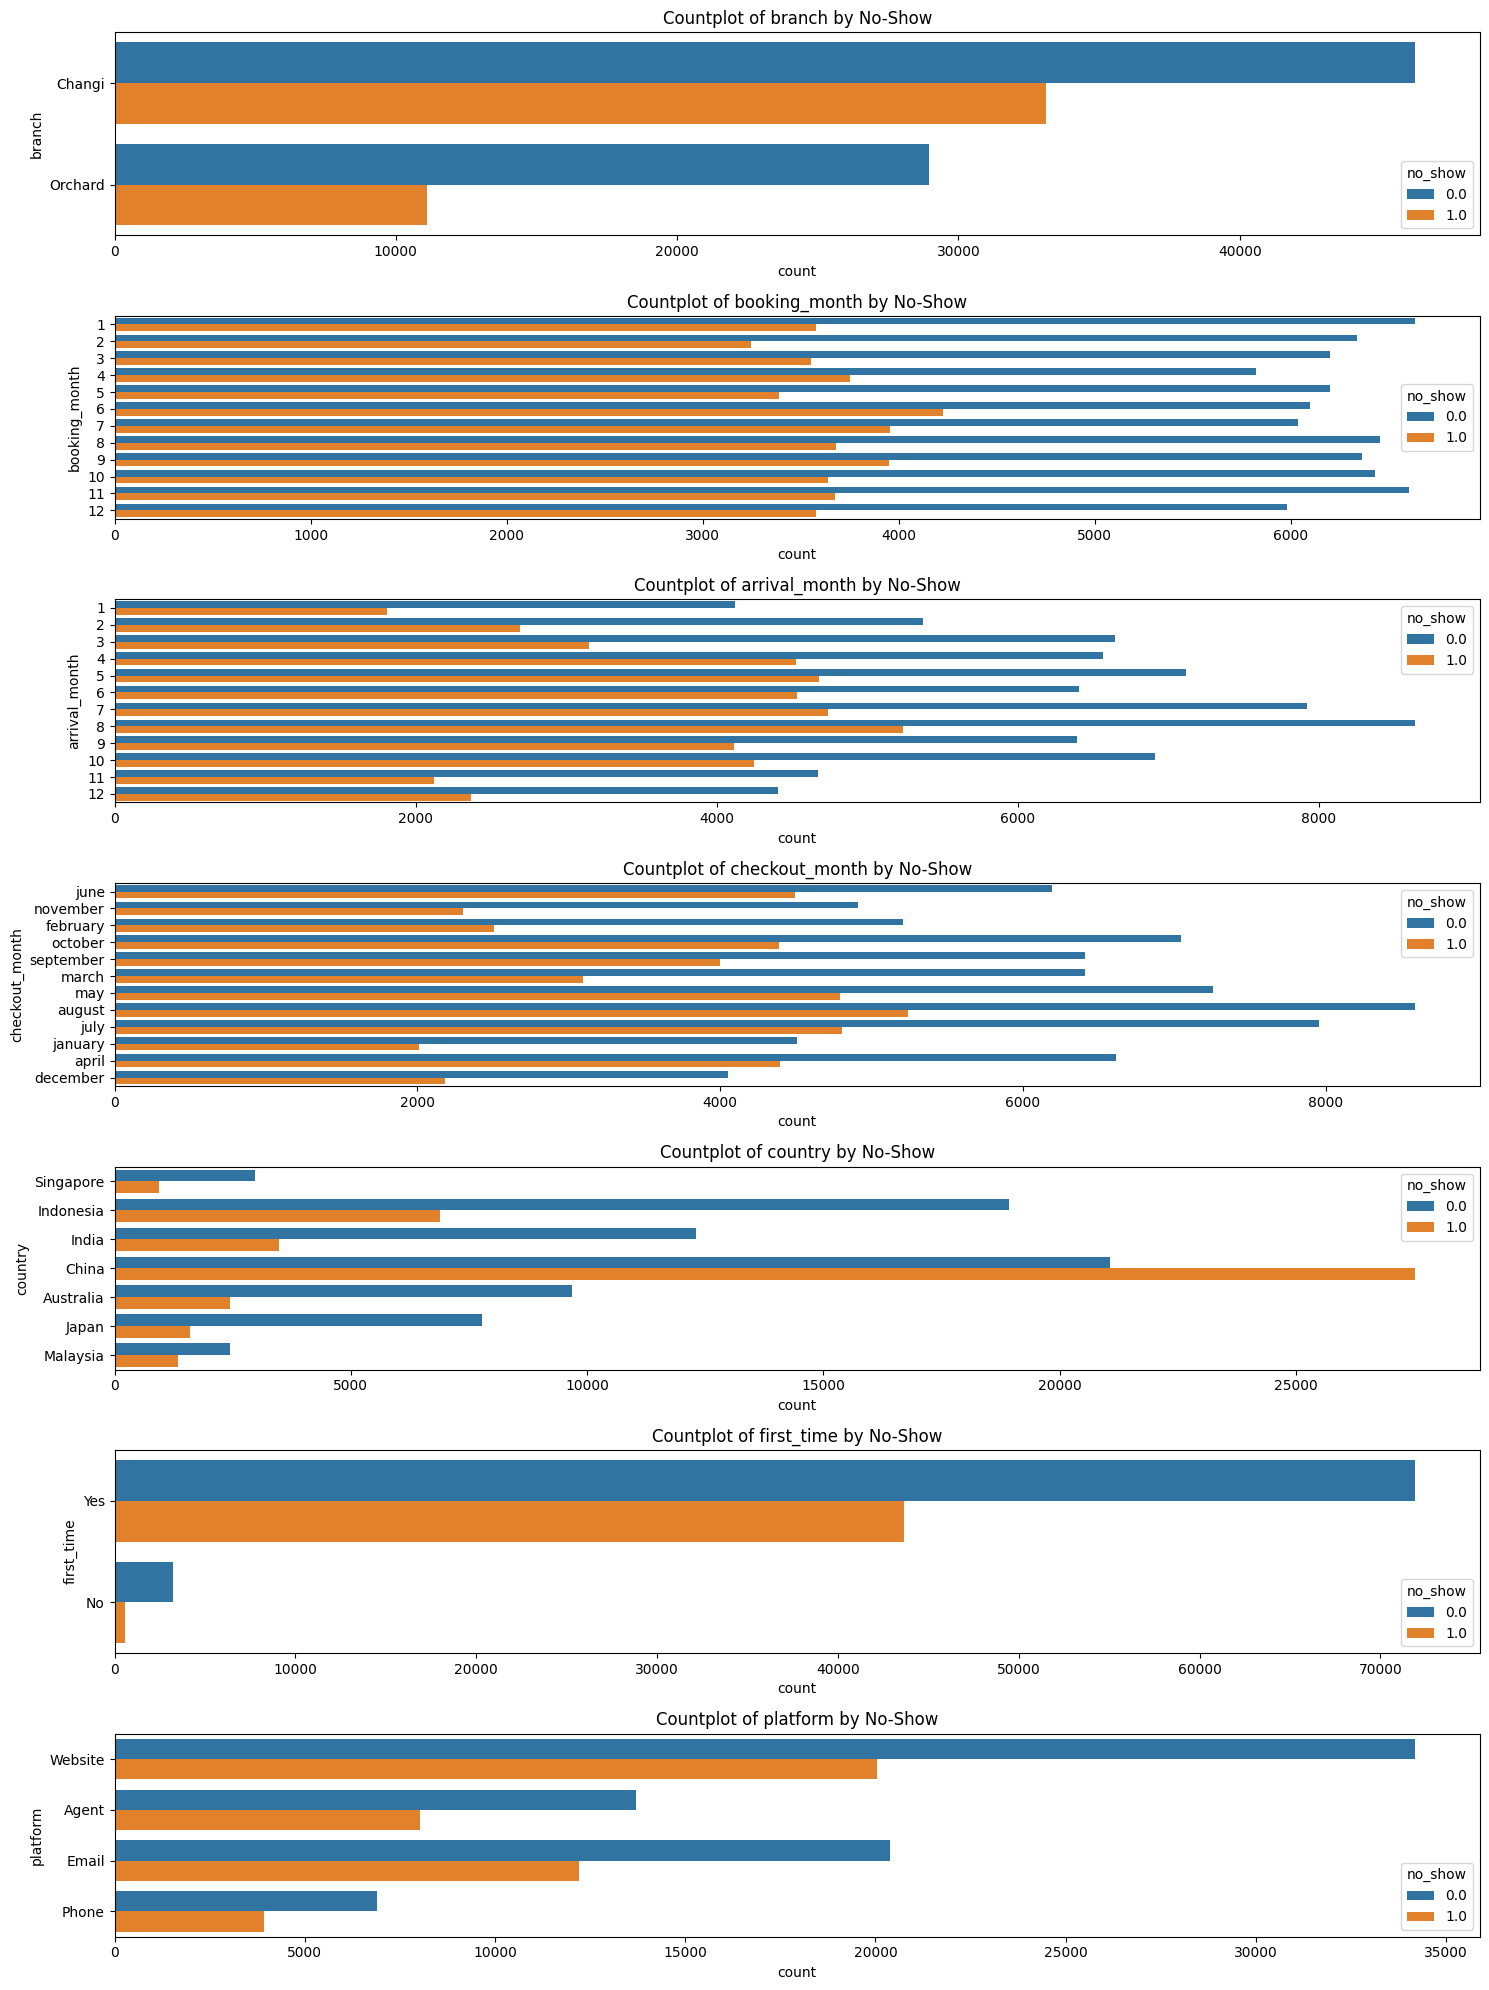

In [ ]:
categorical_variables = ['branch', 'booking_month', 'arrival_month', 
                         'checkout_month', 'country', 'first_time', 'platform']

fig, axes = plt.subplots(nrows=len(categorical_variables), ncols=1, figsize=(15, 20))

for i, var in enumerate(categorical_variables):
    sns.countplot(data=df, y=var, hue='no_show', ax=axes[i])
    axes[i].set_title(f'Countplot of {var} by No-Show')
    
plt.tight_layout()
plt.show()

In [105]:
for var in categorical_variables: 
    print(f"Percentage of no_show = 1 for each value of {var}")
    percentage_noshow = df.groupby(var)['no_show'].mean() * 100.0 
    print(percentage_noshow)
    print("---------------------------")

Percentage of no_show = 1 for each value of branch
branch
Changi     41.726963
Orchard    27.763355
Name: no_show, dtype: float64
---------------------------
Percentage of no_show = 1 for each value of booking_month
booking_month
1     35.049931
2     33.886108
3     36.426082
4     39.180859
5     35.335836
6     40.924060
7     39.587711
8     36.293665
9     38.284052
10    36.154152
11    35.768482
12    37.433323
Name: no_show, dtype: float64
---------------------------
Percentage of no_show = 1 for each value of arrival_month
arrival_month
1     30.477315
2     33.415964
3     32.152338
4     40.797186
5     39.665847
6     41.457172
7     37.453598
8     37.753117
9     39.170156
10    38.046595
11    31.233441
12    34.970501
Name: no_show, dtype: float64
---------------------------
Percentage of no_show = 1 for each value of checkout_month
checkout_month
april        39.923747
august       37.908355
december     35.016835
february     32.503888
january      30.831799
july     

<div class="alert alert-block alert-info" style="background-color: #FEDAE8; color: black;">
- Changi branch had a higher percentage of no-show compared to Orchard branch. </br>
- Percentage of no-show appeared relatively consistent across all booking months (30-40%), although it was a bit higher for the month of April, June and July. </br>
- Percentage of no-show appeared relatively consistent across all arrival months (30-40%), although it was a bit higher for the month of April, May, June and September. </br>
- Percentage of no-show was higher when checkout month was June (42.1%) as compared to other checkout months (< 40%). </br>
- China had twice as much no-show (56.6%) compared to customers from other countries, followed by Malaysia (35.4%). </br>
- Percentage of no-show among first-time customers was 2.5 times that among repeated customers. </br>
- Percentage of no-show was relatively constant across all platforms. </br>

Categorical variables that are of importance in predicting no-show: branch, booking month, arrival month, checkout month, country and first-time. 
</div>

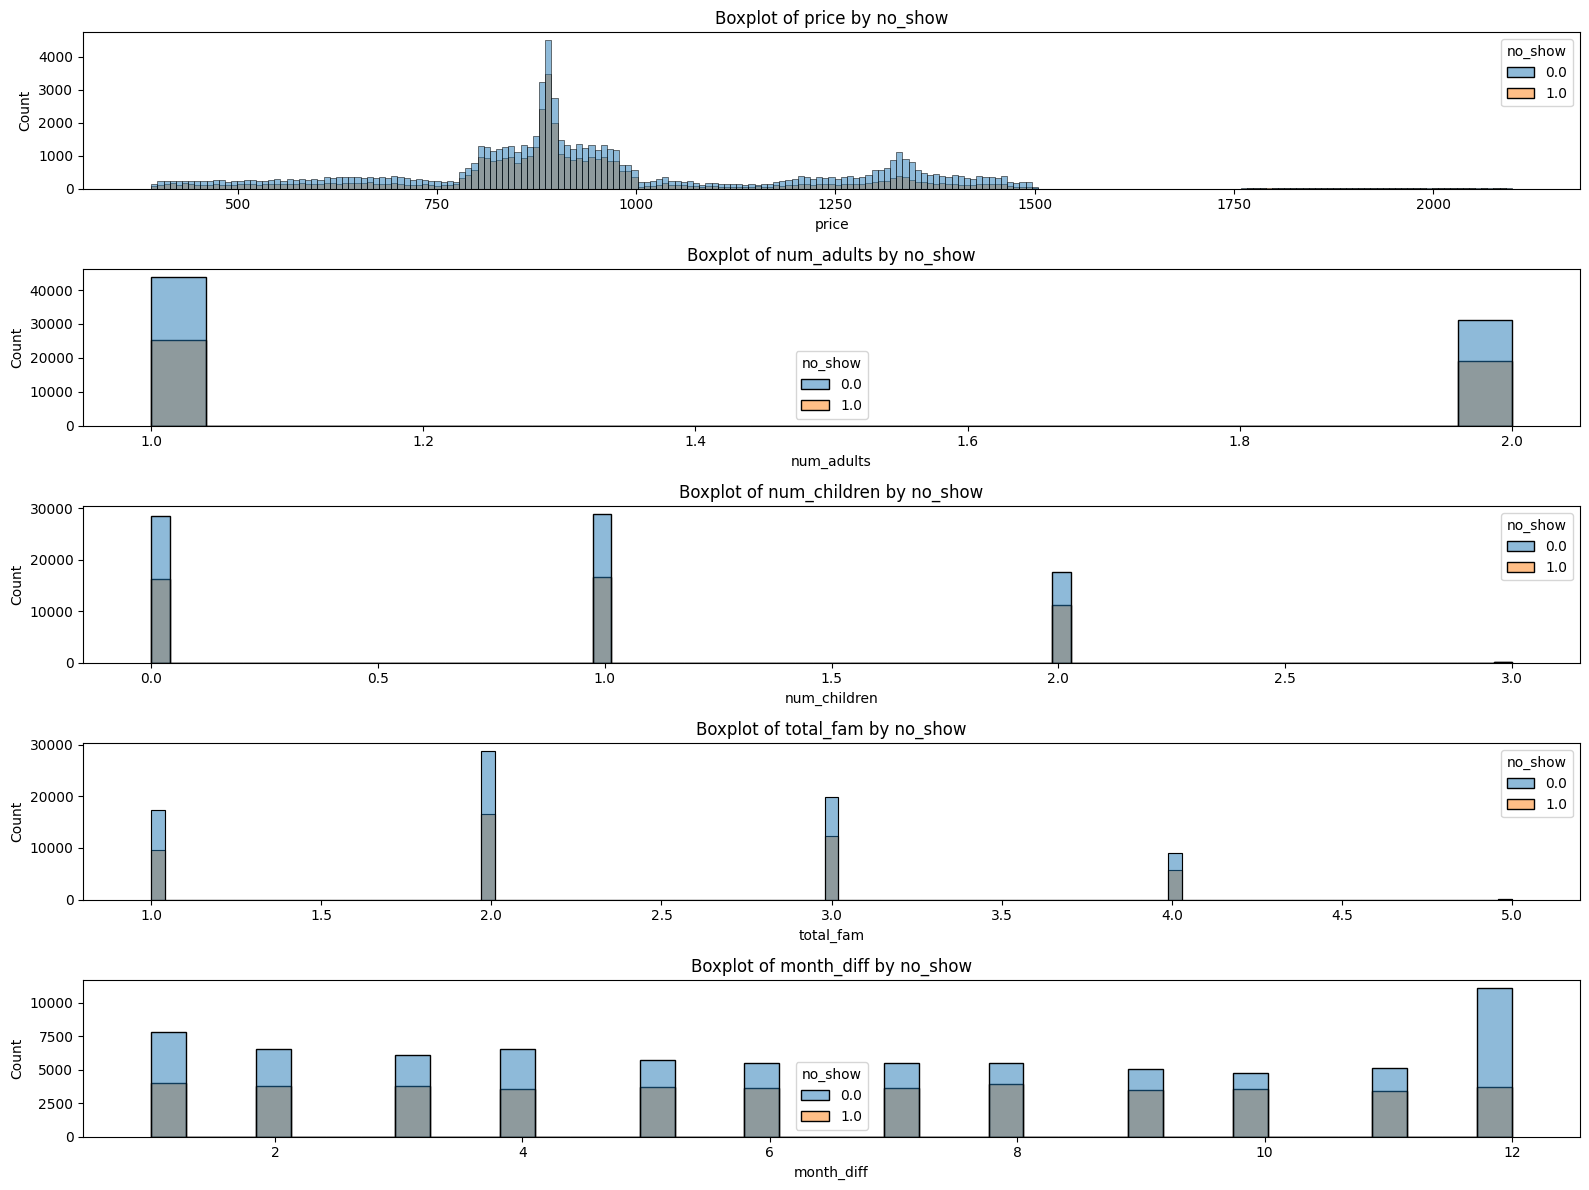

In [112]:
df['num_adults'] = df['num_adults'].astype(float)

numerical_variables = ['price', 'num_adults', 'num_children', 'total_fam', 'month_diff']
fig, axes = plt.subplots(nrows=len(numerical_variables), ncols=1, figsize=(16, 12))

for i, var in enumerate(numerical_variables): 
    sns.histplot(x = var, hue = 'no_show', data = df, ax=axes[i])
    axes[i].set_title(f'Boxplot of {var} by no_show')

plt.tight_layout()
plt.show()

In [114]:
for var in numerical_variables: 
    group_0 = df[df['no_show'] == 0.0][var]
    group_1 = df[df['no_show'] == 1.0][var]

    stat, p_value = stats.kruskal(group_0, group_1)
    print(f"Kruskal-Wallis test for {var}:")
    print(f"  p-value: {p_value}")
    if p_value < 0.05:
        print("  Result: Significant difference (reject null hypothesis)")
    else:
        print("  Result: No significant difference (fail to reject null hypothesis)")
    print("")

Kruskal-Wallis test for price:
  p-value: 3.9800618151416996e-81
  Result: Significant difference (reject null hypothesis)

Kruskal-Wallis test for num_adults:
  p-value: 5.376850762937086e-07
  Result: Significant difference (reject null hypothesis)

Kruskal-Wallis test for num_children:
  p-value: 1.999642252892041e-10
  Result: Significant difference (reject null hypothesis)

Kruskal-Wallis test for total_fam:
  p-value: 5.207530042348695e-16
  Result: Significant difference (reject null hypothesis)

Kruskal-Wallis test for month_diff:
  p-value: 2.559240909914486e-09
  Result: Significant difference (reject null hypothesis)



<div class="alert alert-block alert-info" style="background-color: #FEDAE8; color: black;">
Based on Kruskal-Wallis test, there was significant difference in the median of price, number of adults, number of children, total family size and difference between booking and arrival month depending on whether the customer showed up in the end. 
</div>